# Planner tutorial

Trident includes a :class:`pydent.planner.Planner` to handle experimental
planning. To get started, lets first open a new Planner instance:

In [0]:
from mysession import local as session
from pydent.planner import Planner

planner = Planner(session)

The planning object instantiates a new plan for you. Of source,
there are no wires or operations in the plan just yet:

In [2]:
print(planner.plan)
print(planner.plan.operations)

<Plan id=None rid=0>
None


We can create new operations from their :class:`pydent.models.OperationType` if we know the operation type's name, id, or have an OperationType instance. All of the following will create a new operation from the `Make PCR Fragment` operation type:


In [0]:
ot = session.OperationType.find_by_name("Make PCR Fragment")

pcr_op = planner.new_op(ot)
pcr_op = planner.new_op(ot.id)
pcr_op = planner.new_op(ot.name)

We can add a wire explicitly between two field values:

In [4]:
op1 = planner.new_op("Make PCR Fragment")
op2 = planner.new_op("Run Gel")

print("op1 outputs")
for fv in op1.outputs:
  print("\t" + fv.name)
print()

print("op2 inputs")
for fv in op2.inputs:
  print("\t" + fv.name)
  
new_wire = planner.add_wire(op1.output('Fragment'), op2.input('Fragment'))

op1 outputs
	Fragment

op2 inputs
	Fragment
	Gel


However, if we tried to wire a `Fragment` output to a `Gel` input, we will get an error as there are no allowable field types that match the output to the input

In [5]:
try:
  new_wire = planner.add_wire(op1.output('Fragment'), op2.input('Gel'))
except Exception as e:
  print(e)

Cannot wire "Fragment" to "Gel". No allowable field types match.


You can see the above code can become pretty cumbersome with many operations and wires. Most operations only contain a handful of inputs and outputs and the wiring can often be inferred from whether allowable field types can match between outputs and inputs. In this case, the Planner provide the ability to quickly
chain together operations:

In [0]:
planner = Planner(session)
ops = planner.chain("Make PCR Fragment", "Run Gel", "Extract Gel Slice", "Purify Gel Slice")
pcr_op = ops[0]
purify_op = ops[-1]

We can also include specific operation instances in the chain. The following will create a Pour Gel and wire it the the only available input of Run Gel:

In [7]:
planner.chain("Pour Gel", ops[1])

We can take a look at the wires and see there are 

In [8]:
def print_fv(fv):
  return "{}.{}".format(fv.operation.operation_type.name, fv.name)

def print_wire(w):
  return "{} -> {}".format(print_fv(w.source), print_fv(w.destination))

for w in planner.plan.wires:
  print(print_wire(w))

Make PCR Fragment.Fragment -> Run Gel.Fragment
Run Gel.Fragment -> Extract Gel Slice.Fragment
Extract Gel Slice.Fragment -> Purify Gel Slice.Gel
Pour Gel.Lane -> Run Gel.Gel


Now what we have is a blank plan template. Inputs and outputs have not been assigned inventory or samples.
We can assign values to field values using the following to 

In [9]:
fv = pcr_op.output('Fragment')
st = session.SampleType.find_by_name("Fragment")
s = session.Sample.one(query={"sample_type_id": st.id})
planner.set_field_value(fv, sample=s)

pcr_op.outputs[0].sample

However, we see that other operations do not have their inputs or outputs set:

In [0]:
assert purify_op.outputs[0].sample is None

The Planner can use the wires and OperationType to automatically set samples across wires and field values. We can see that the output of `Extract Gel Slice` now has a sample set as well.

In [11]:
fv = pcr_op.output('Fragment')
st = session.SampleType.find_by_name("Fragment")
s = session.Sample.one(query={"sample_type_id": st.id})
planner.set_field_value_and_propogate(fv, sample=s)

purify_op.outputs[0].sample

In some special cases, the inputs of operations can be inferred from the sample properties. For example, Fragments may have a 'Template', 'Reverse Primer' and 'Forward Primer' attributes. These could be used to set the inputs of the `Make PCR Fragment` operation:

In [12]:
planner.set_output_sample(pcr_op.outputs[0], sample=s)

print(s.properties)
for fv in pcr_op.inputs:
  print(fv.sample)

{'Sequence': None, 'Length': 704, 'Template': None, 'Forward Primer': None, 'Reverse Primer': None, 'Restriction Enzyme(s)': None, 'Yeast Marker': None, 'Fragment Mix Array': [<pydent.models.sample.Sample object at 0xa1d8f7240>, <pydent.models.sample.Sample object at 0xa1da1d120>, <pydent.models.sample.Sample object at 0xa1da1d360>, <pydent.models.sample.Sample object at 0xa1da1bea0>, <pydent.models.sample.Sample object at 0xa1d958f30>, <pydent.models.sample.Sample object at 0xa1d971438>, <pydent.models.sample.Sample object at 0xa1da2dcf0>, <pydent.models.sample.Sample object at 0xa1da37048>, <pydent.models.sample.Sample object at 0xa1da32510>, <pydent.models.sample.Sample object at 0xa1da36318>, <pydent.models.sample.Sample object at 0xa1da42a68>, <pydent.models.sample.Sample object at 0xa1da37a68>, <pydent.models.sample.Sample object at 0xa1da46ea0>, <pydent.models.sample.Sample object at 0xa1da42c18>]}
None
None
None


The planner also has a class for modifying the layout of the operations on the Aquarium server. To If using a jupyter notebook, we can print off the layout to the cell.

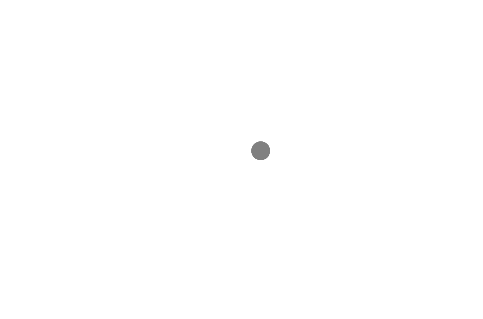

In [13]:
%matplotlib inline

planner.layout.draw()

We may find the layout is messy or operations are overlapping. We can prettify the layout using the following:

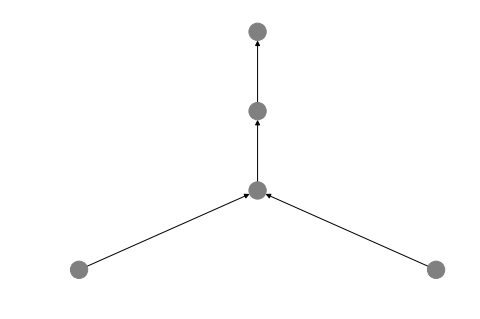

In [14]:
planner.layout.prettify()
planner.layout.draw()

We can treat Planners like templates and split and combine as needed. For example, if we wanted two of the same Plan template, we could do any of the following:

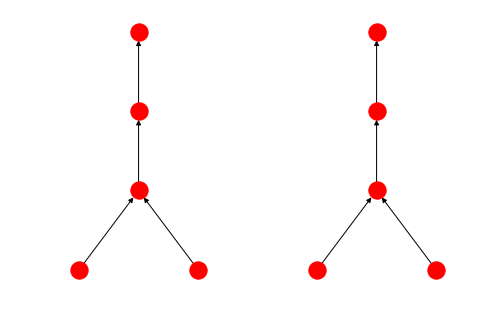

In [15]:
combined_planner = planner + planner
combined_planner = planner * 2
combined_planner = Planner.combine([planner, planner])

# draw
combined_planner.layout.prettify()
combined_planner.draw()

We can split apart a plan:

2


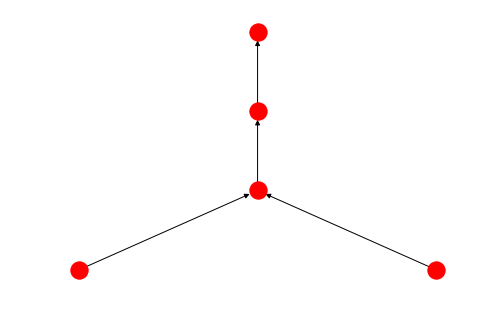

In [18]:
plans = combined_planner.split()
print(len(plans))
plans[0].draw()

Finally, if we want to save the plan to the server, we can just call `save()`:

In [16]:
planner.save()
print(planner.plan.id)  # should have a server id now

33845


If in a jupyter notebook, we can display a html link to the plan:

In [17]:
planner.ipython_link()